# Assignment:  Segmenting and Clustering Neighborhoods in Toronto 

### 1. Start by creating a new Notebook for this assignment.

### Installing and importing libraries

In [3]:
#Installing lxml to read the html-file
!pip install lxml
!pip install html5lib
!pip install BeautifulSoup4
!conda install -c conda-forge geopy --yes 
from geopy.geocoders import Nominatim # module to convert an address into latitude and longitude values
import pandas as pd
import numpy as np
import html5lib
import lxml
from geopy.geocoders import Nominatim
#!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe
import requests
from geopy import distance
from geopy import Point
%matplotlib inline 
import matplotlib as mpl
import matplotlib.pyplot as plt
print('your playground is ready. Go and start playing ...')

Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 4.5.11
  latest version: 4.7.11

Please update conda by running

    $ conda update -n base -c defaults conda



# All requested packages already installed.

your playground is ready. Go and start playing ...


#### We scrape the Wikipedia page, https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M, in order to obtain the data that is in the table of postal codes and to transform the data into a pandas dataframe:

In [4]:
wiki_url = 'https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M'
dfs = pd.read_html(wiki_url) # dfs is a list and its first element is the dataframe
#Toronto_df = pd.concat(dfs)
Toronto_df=dfs[0]
# We check teh properties of the dataframe
Toronto_df.head()
type(Toronto_df)
Toronto_df.info()
Toronto_df.shape

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 288 entries, 0 to 287
Data columns (total 3 columns):
Postcode         288 non-null object
Borough          288 non-null object
Neighbourhood    288 non-null object
dtypes: object(3)
memory usage: 6.9+ KB


(288, 3)

In [5]:
# Now, we clean the data:
Toronto_df.head()
# Only process the cells that have an assigned borough. Ignore cells with a borough that is Not assigned.
Toronto_df = Toronto_df[Toronto_df.Borough != 'Not assigned']
Toronto_df.head()

,Postcode,Borough,Neighbourhood
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,Harbourfront
5,M5A,Downtown Toronto,Regent Park
6,M6A,North York,Lawrence Heights


In [6]:
#More than one neighborhood can exist in one postal code area. For example, in the table on the Wikipedia page, you will notice that M5A is listed twice and has two neighborhoods: Harbourfront and Regent Park. These two rows will be combined into one row with the neighborhoods separated with a comma as shown in row 11 in the above table.
#Toronto_df=Toronto_df.groupby('Postcode', as_index=False).agg(lambda x: ', '.join(set(x.dropna())))
#Toronto_df
#If a cell has a borough but a Not assigned neighborhood, then the neighborhood will be the same as the borough. So for the 9th cell in the table on the Wikipedia page, the value of the Borough and the Neighborhood columns will be Queen's Park.
Toronto_df['Neighbourhood'] = Toronto_df.apply(lambda x: x['Borough'] if x['Neighbourhood']=='Not assigned' else x['Neighbourhood'] , axis=1)
Toronto_df.head()

/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


,Postcode,Borough,Neighbourhood
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,Harbourfront
5,M5A,Downtown Toronto,Regent Park
6,M6A,North York,Lawrence Heights


In [7]:
# I checked if there exist any duplicate row in the dataframe
Toronto_df = Toronto_df.drop_duplicates()
#I sorted the values of the column alphabetically according to the column Borough
Toronto_df.sort_values('Borough')
#In the last cell of your notebook, use the .shape method to print the number of rows of your dataframe.
Toronto_df.shape
Toronto_df.head()

,Postcode,Borough,Neighbourhood
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,Harbourfront
5,M5A,Downtown Toronto,Regent Park
6,M6A,North York,Lawrence Heights


- Now that you have built a dataframe of the postal code of each neighborhood along with the borough name and neighborhood name, in order to utilize the Foursquare location data, we need to get the latitude and the longitude coordinates of each neighborhood.

In [8]:
Geo_df=pd.read_csv("http://cocl.us/Geospatial_data")
Geo_df.head()
#The column of Toronto_df for the postal code is "Postcode" and for the dataframe Geo_df it is called "Postal Code". So we have to rename it, in order to be able to merge the both dataframe together
Geo_df=Geo_df.rename(columns={"Postal Code": "Postcode"})
Geo_df.head()
# Now, we merge both dataframes
Toronto_Neighbourhood_df = pd.merge(Toronto_df, Geo_df, on='Postcode')
#We do not Postcode for the dataframe in the map
neighborhoods=Toronto_Neighbourhood_df.drop(columns=['Postcode'])
neighborhoods.head()
print('The dataframe has {} boroughs and {} neighborhoods.'.format(
        len(Toronto_Neighbourhood_df['Borough'].unique()),
        Toronto_Neighbourhood_df.shape[0]
    )
)
neighborhoods.head()

The dataframe has 11 boroughs and 211 neighborhoods.


,Borough,Neighbourhood,Latitude,Longitude
0,North York,Parkwoods,43.753259,-79.329656
1,North York,Victoria Village,43.725882,-79.315572
2,Downtown Toronto,Harbourfront,43.654260,-79.360636
3,Downtown Toronto,Regent Park,43.654260,-79.360636
4,North York,Lawrence Heights,43.718518,-79.464763


## Explore Neighborhoods in Toronto

- we use geopy library to get the latitude and longitude values of Toronto.

In [9]:
address = 'Toronto'

geolocator = Nominatim(user_agent="Toronto_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Toronto are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Toronto are 43.653963, -79.387207.


- and now the map of Toronto

In [10]:
# create map of Toronto using latitude and longitude values
map_Toronto = folium.Map(location=[latitude, longitude], zoom_start=11)

# add markers to map
for lat, lng, borough, neighborhood in zip(neighborhoods['Latitude'], neighborhoods['Longitude'], neighborhoods['Borough'], neighborhoods['Neighbourhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_Toronto)  
    
map_Toronto

- We concentrate on the Borough of Downtown Toronto in Toronto

In [11]:
Toronto_downtown = neighborhoods[neighborhoods['Borough']=='Downtown Toronto'].reset_index(drop=True)
Toronto_downtown.head()

,Borough,Neighbourhood,Latitude,Longitude
0,Downtown Toronto,Harbourfront,43.654260,-79.360636
1,Downtown Toronto,Regent Park,43.654260,-79.360636
2,Downtown Toronto,Ryerson,43.657162,-79.378937
3,Downtown Toronto,Garden District,43.657162,-79.378937
4,Downtown Toronto,St. James Town,43.651494,-79.375418


- Let's get the geographical coordinates of Downtown-Toronto and its map

In [12]:
address = 'Downtown Toronto'
geolocator = Nominatim(user_agent="Toronto_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Downtown-Toronto are {}, {}.'.format(latitude, longitude))

# create map of Downtown Toronto using latitude and longitude values
map_torontodowntoan = folium.Map(location=[latitude, longitude], zoom_start=13)

# add markers to map
for lat, lng, label in zip(Toronto_downtown['Latitude'], Toronto_downtown['Longitude'], Toronto_downtown['Neighbourhood']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='red',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_torontodowntoan)  
    
map_torontodowntoan

The geograpical coordinate of Downtown-Toronto are 43.654027, -79.3802003.


In [13]:
#Let's see how many Neighborhood has Downtown in Toronto
Toronto_downtown.count()[0]

37

- Now that you have built a dataframe of the postal code of each neighborhood along with the borough name and neighborhood name, in order to utilize the Foursquare location data, we need to get the latitude and the longitude coordinates of each neighborhood.

In [14]:
CLIENT_ID = 'MFAV1TEFM3VS1ZAD4AIOXUPKYZDNUZCLE235SQETXOSOWM0X' # your Foursquare ID
CLIENT_SECRET = '1NMKVB04Y43XSTTPD0OLFHOTPVKNMHZXLT4H5B4L1O3DNQXY' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version
#let's get the top 100 venues that are in Marble Hill within a radius of 500 meters.
LIMIT = 100 # limit of number of venues returned by Foursquare API

radius = 500 # define radius
#print('Your credentails:')
#print('CLIENT_ID: ' + CLIENT_ID)
#print('CLIENT_SECRET:' + CLIENT_SECRET )

### Toronto_downtown has many Neighbourhoods, lets explore the Neighborhoods in Toronto_downtown

In [15]:
# Let's create a function to repeat the same process to all the neighborhoods in  Toronto_downtown
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

- Now write the code to run the above function on each neighborhood and create a new dataframe called *Toronto-Downtown_venues*.

In [16]:
Toronto_downtown_venues = getNearbyVenues(names=Toronto_downtown['Neighbourhood'],
                                   latitudes=Toronto_downtown['Latitude'],
                                   longitudes=Toronto_downtown['Longitude']
                                  )
Toronto_downtown_venues.shape

Harbourfront
Regent Park
Ryerson
Garden District
St. James Town
Berczy Park
Central Bay Street
Christie
Adelaide
King
Richmond
Harbourfront East
Toronto Islands
Union Station
Design Exchange
Toronto Dominion Centre
Commerce Court
Victoria Hotel
Harbord
University of Toronto
Chinatown
Grange Park
Kensington Market
CN Tower
Bathurst Quay
Island airport
Harbourfront West
King and Spadina
Railway Lands
South Niagara
Rosedale
Stn A PO Boxes 25 The Esplanade
Cabbagetown
St. James Town
First Canadian Place
Underground city
Church and Wellesley


(2497, 7)

In [17]:
print(Toronto_downtown_venues.shape)
Toronto_downtown_venues.head()

(2497, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Harbourfront,43.65426,-79.360636,Roselle Desserts,43.653447,-79.362017,Bakery
1,Harbourfront,43.65426,-79.360636,Tandem Coffee,43.653559,-79.361809,Coffee Shop
2,Harbourfront,43.65426,-79.360636,Toronto Cooper Koo Family Cherry St YMCA Centre,43.653191,-79.357947,Gym / Fitness Center
3,Harbourfront,43.65426,-79.360636,Body Blitz Spa East,43.654735,-79.359874,Spa
4,Harbourfront,43.65426,-79.360636,Morning Glory Cafe,43.653947,-79.361149,Breakfast Spot


- Now we check what Venue Categories exist in Toronto Downtown

In [18]:
# all the Categories
Toronto_downtown_venues=Toronto_downtown_venues.rename(columns={"Venue Category": "VCategory"})
Toronto_downtown_venues.VCategory.unique()

array(['Bakery', 'Coffee Shop', 'Gym / Fitness Center', 'Spa',
       'Breakfast Spot', 'Restaurant', 'Pub', 'Park', 'Historic Site',
       'Chocolate Shop', 'Farmers Market', 'Dessert Shop',
       'Performing Arts Venue', 'Mexican Restaurant', 'French Restaurant',
       'Café', 'Shoe Store', 'Event Space', 'Ice Cream Shop',
       'Italian Restaurant', 'Cosmetics Shop', 'Theater', 'Art Gallery',
       'Brewery', 'Electronics Store', 'Bank', 'Beer Store',
       'Health Food Store', 'Antique Shop', 'Clothing Store',
       'Burrito Place', 'Pizza Place', 'Comic Shop', 'Plaza', 'Tea Room',
       'Ramen Restaurant', 'Diner', 'Thai Restaurant', 'Burger Joint',
       'Taco Place', 'Movie Theater', 'Sandwich Place', 'Music Venue',
       'Beer Bar', 'Vegetarian / Vegan Restaurant', 'Steakhouse',
       'Shopping Mall', 'Fast Food Restaurant', 'American Restaurant',
       'Japanese Restaurant', 'Hotel', 'Sporting Goods Shop', 'Gastropub',
       'Middle Eastern Restaurant', 'Sushi Res

In [19]:
Toronto_downtown_venues.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,VCategory
0,Harbourfront,43.65426,-79.360636,Roselle Desserts,43.653447,-79.362017,Bakery
1,Harbourfront,43.65426,-79.360636,Tandem Coffee,43.653559,-79.361809,Coffee Shop
2,Harbourfront,43.65426,-79.360636,Toronto Cooper Koo Family Cherry St YMCA Centre,43.653191,-79.357947,Gym / Fitness Center
3,Harbourfront,43.65426,-79.360636,Body Blitz Spa East,43.654735,-79.359874,Spa
4,Harbourfront,43.65426,-79.360636,Morning Glory Cafe,43.653947,-79.361149,Breakfast Spot


### Now we search for all the Cafes in downtown

In [20]:
Toronto_downtown_Cafes=Toronto_downtown_venues[Toronto_downtown_venues['VCategory'].str.contains('Caf', regex=False, case=False, na=False)]
Toronto_downtown_Cafes.shape
Toronto_downtown_Coffees=Toronto_downtown_venues[Toronto_downtown_venues['VCategory'].str.contains('Coffee', regex=False, case=False, na=False)]
Toronto_downtown_Coffees.shape
Toronto_Cafes = [Toronto_downtown_Cafes, Toronto_downtown_Coffees]
Toronto_Cafes = pd.concat(Toronto_Cafes)
Toronto_Cafes.shape
print('There exists '+ str(Toronto_Cafes.shape[0]) +' Cafes in Downtown')

There exists 357 Cafes in Downtown


In [21]:
# we check for duplicates
Toronto_Cafes.drop_duplicates(keep=False,inplace=True) 
Toronto_Cafes.shape
Toronto_Cafes.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,VCategory
24,Harbourfront,43.65426,-79.360636,ODIN Cafe + Bar,43.656739,-79.356503,Café
27,Harbourfront,43.65426,-79.360636,Caffe Furbo,43.649970,-79.358849,Café
36,Harbourfront,43.65426,-79.360636,Wildly Delicious Cafe,43.650436,-79.358862,Café
69,Regent Park,43.65426,-79.360636,ODIN Cafe + Bar,43.656739,-79.356503,Café
72,Regent Park,43.65426,-79.360636,Caffe Furbo,43.649970,-79.358849,Café


- to check if in every Neighborhood there exists at least one Cafe

In [22]:
#Toronto_downtown_venues
list_Cafes=Toronto_Cafes['Neighborhood'].str[0]
len(list_Cafes)
list_Cafes = list( dict.fromkeys(list_Cafes) ) 
list_downtowan=Toronto_downtown_venues['Neighborhood'].str[0]
len(list_downtowan)
list_downtowan = list( dict.fromkeys(list_downtowan) ) 
len(list_Cafes)==len(list_downtowan)

True

- We check for all the neighborhoods which have Cafes, which are also all the neighborhoods in Downtown

In [23]:
Toronto_Cafes = Toronto_Cafes[['Neighborhood']]
Toronto_Cafes.head()

,Neighborhood
24,Harbourfront
27,Harbourfront
36,Harbourfront
69,Regent Park
72,Regent Park


- Now, we want to know how many Cafes do exist in each neighborhood

In [24]:
Toronto_Cafes=Toronto_Cafes.groupby(Toronto_Cafes.columns.tolist(),as_index=False).size().to_frame()
Toronto_Cafes.columns = ['Cafes']
Toronto_Cafes.head()
#Toronto_Cafes=Toronto_Cafes.reset_index()
#Toronto_Cafes
#Toronto_Cafes.columns = ['Neighborhood', 'Cafes']
#Toronto_Cafes.head()

,Cafes
Neighborhood,
Adelaide,13
Bathurst Quay,1
Berczy Park,7
CN Tower,1
Cabbagetown,5


- Check the distribution of the Cafes in Downtown with a bar-diaagram

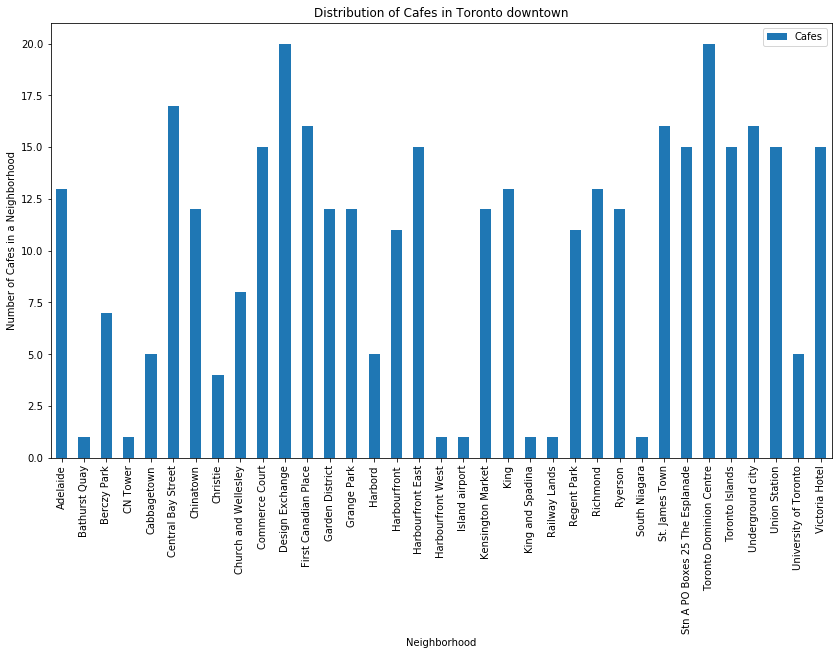

In [25]:
Toronto_Cafes.plot(kind='bar', figsize=(14, 8))
# use the inline backend to generate the plots within the browser
plt.xlabel('Neighborhood') # add to x-label to the plot
plt.ylabel('Number of Cafes in a Neighborhood') # add y-label to the plot
plt.title('Distribution of Cafes in Toronto downtown') # add title to the plot
plt.show()

### Let us check the neighborhoods who have Theaters

In [26]:
Toronto_downtown_Theaters=Toronto_downtown_venues[Toronto_downtown_venues['VCategory'].str.contains('Theater', regex=False, case=False, na=False)]
Toronto_downtown_Theaters.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,VCategory
34,Harbourfront,43.654260,-79.360636,Soulpepper Theatre,43.650780,-79.357615,Theater
79,Regent Park,43.654260,-79.360636,Soulpepper Theatre,43.650780,-79.357615,Theater
98,Ryerson,43.657162,-79.378937,Ed Mirvish Theatre,43.655102,-79.379768,Theater
104,Ryerson,43.657162,-79.378937,Cineplex Cinemas,43.656126,-79.380390,Movie Theater
123,Ryerson,43.657162,-79.378937,Elgin And Winter Garden Theatres,43.653394,-79.378507,Theater


In [27]:
#let us see the neighborhoods with Theaters
Toronto_theaters = Toronto_downtown_Theaters[['Neighborhood']]
Toronto_theaters.head()

,Neighborhood
34,Harbourfront
79,Regent Park
98,Ryerson
104,Ryerson
123,Ryerson


In [28]:
Toronto_theaters=Toronto_theaters.groupby(Toronto_theaters.columns.tolist(),as_index=False).size().to_frame()
#Toronto_theaters=Toronto_theaters.reset_index()
#Toronto_theaters.to_frame()
Toronto_theaters.columns = ['Theaters']
#Toronto_theaters=Toronto_theaters.rename(columns={'0':'No_Cafes'})
Toronto_theaters.head()

,Theaters
Neighborhood,
Adelaide,1
Church and Wellesley,1
Design Exchange,1
First Canadian Place,1
Garden District,3


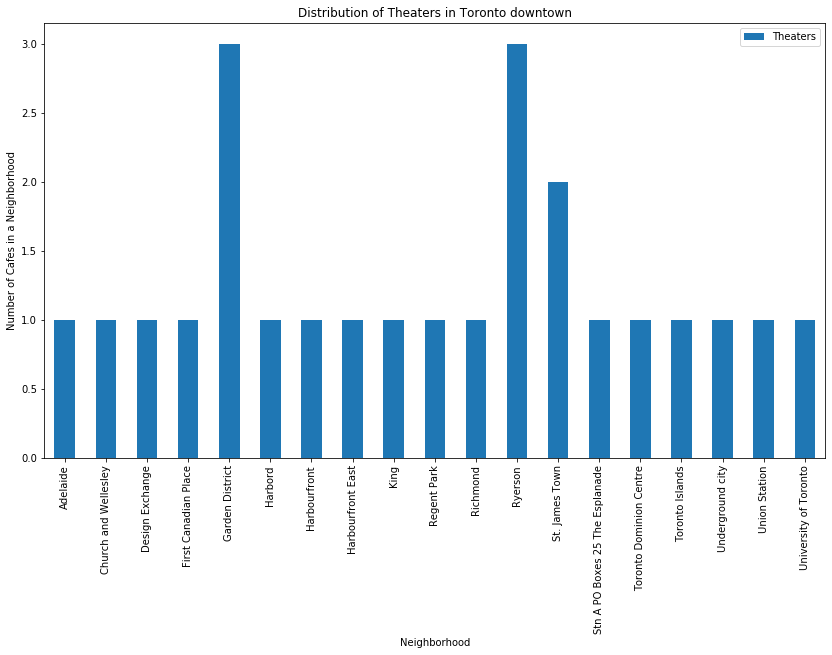

In [29]:
Toronto_theaters.plot(kind='bar', figsize=(14,8))
# use the inline backend to generate the plots within the browser
plt.xlabel('Neighborhood') # add to x-label to the plot
plt.ylabel('Number of Cafes in a Neighborhood') # add y-label to the plot
plt.title('Distribution of Theaters in Toronto downtown') # add title to the plot
plt.show()

In [30]:
Toronto_theaters=Toronto_theaters.reset_index()
Toronto_theaters.head()

,Neighborhood,Theaters
0,Adelaide,1
1,Church and Wellesley,1
2,Design Exchange,1
3,First Canadian Place,1
4,Garden District,3


In [31]:
Toronto_Cafes=Toronto_Cafes.reset_index()
Toronto_Cafes.head()

,Neighborhood,Cafes
0,Adelaide,13
1,Bathurst Quay,1
2,Berczy Park,7
3,CN Tower,1
4,Cabbagetown,5


- Now we should be able to compare the number of Cafes and Theaters in each neighborhood

In [32]:
#so, we merge both dataframes of Cafes and Theaters
Cafes_Theaters=pd.merge(Toronto_theaters, Toronto_Cafes, on='Neighborhood', how='outer')
# the element should be in integer
Cafes_Theaters['Theaters'] = Cafes_Theaters['Theaters'].fillna(0).astype(int)
Cafes_Theaters.head()

,Neighborhood,Theaters,Cafes
0,Adelaide,1,13
1,Church and Wellesley,1,8
2,Design Exchange,1,20
3,First Canadian Place,1,16
4,Garden District,3,12


### Compare the distribution of Cafes and Theaters

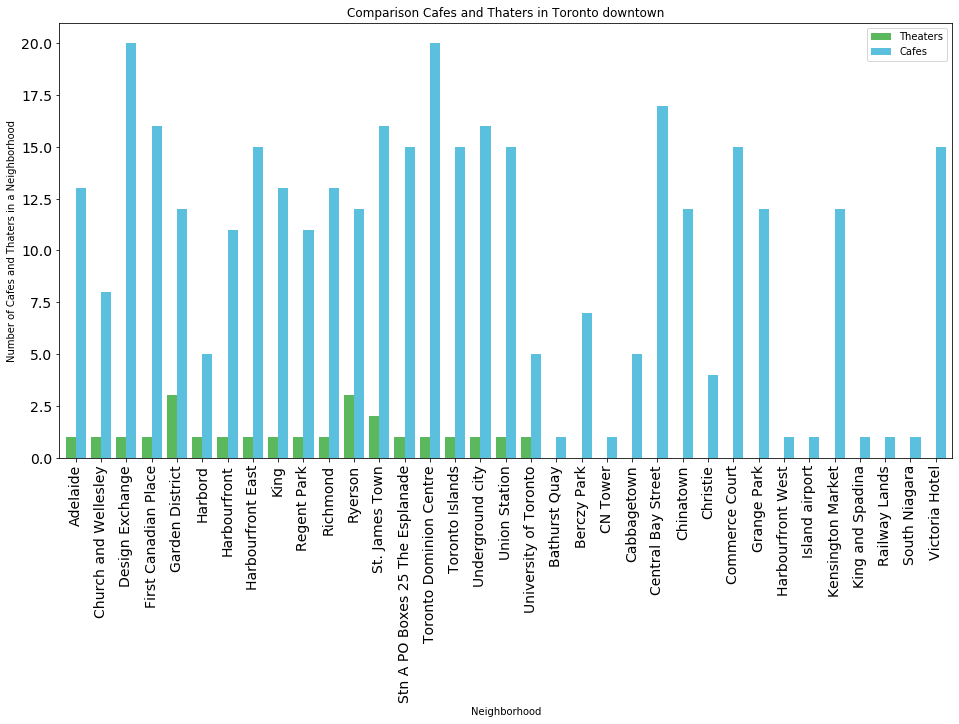

In [33]:
Cafes_Theaters2=Cafes_Theaters.set_index('Neighborhood')
ax=Cafes_Theaters2.plot(kind='bar', figsize=(16, 8), width=0.8,
        color=['#5cb85c', '#5bc0de'],
       fontsize=14)

plt.xlabel('Neighborhood') # add to x-label to the plot
plt.ylabel('Number of Cafes and Thaters in a Neighborhood') # add y-label to the plot
plt.title('Comparison Cafes and Thaters in Toronto downtown') # add title to the plot
plt.show()

- The stacked bar diagram 

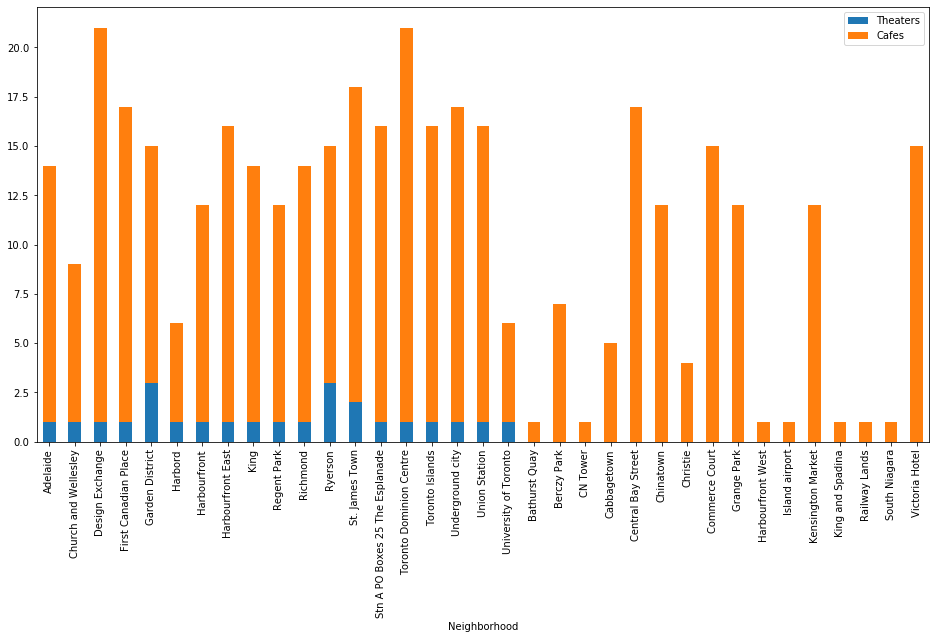

In [34]:
Cafes_Theaters2.plot.bar(figsize=(16, 8),stacked=True);

- Scatter plot of the Cafes in camparion of the Theaters

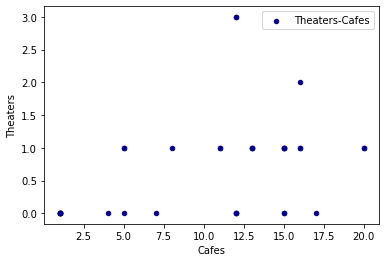

In [35]:
ax = Cafes_Theaters.plot.scatter(x='Cafes', y='Theaters', color='DarkBlue', label='Theaters-Cafes');

- and to see the density of the distribution

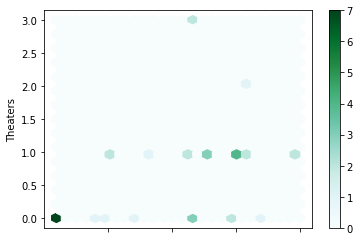

In [36]:
#Hexagonal bin plot
#Hexbin plots can be a useful alternative to scatter plots if your data are too dense to plot each point individually.
Cafes_Theaters.plot.hexbin(x='Cafes', y='Theaters', gridsize=25)

- Now a bubble diagram

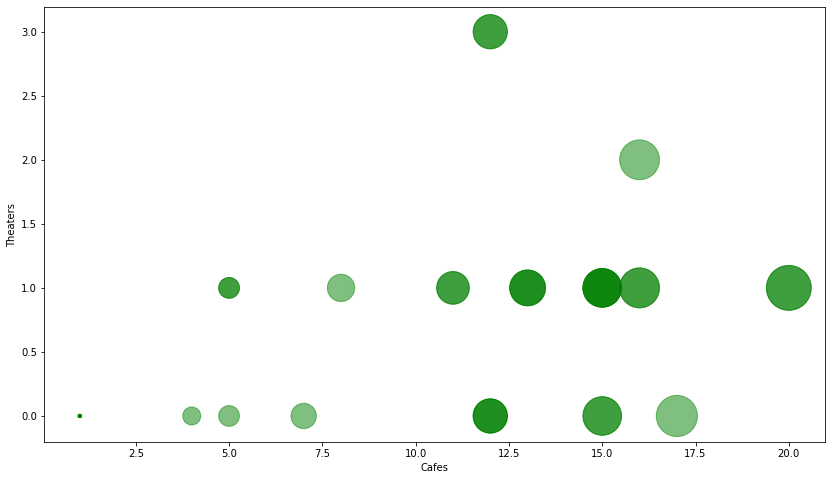

In [37]:
# normalize data
norm_Cafes = (Cafes_Theaters['Cafes'] - Cafes_Theaters['Cafes'].min()) / (Cafes_Theaters['Cafes'].max() - Cafes_Theaters['Cafes'].min())
norm_Theaters = (Cafes_Theaters['Theaters'] - Cafes_Theaters['Theaters'].min()) / (Cafes_Theaters['Theaters'].max() - Cafes_Theaters['Theaters'].min())
#Cafes
ax0 = Cafes_Theaters.plot(kind='scatter',
                    x='Cafes',
                    y='Theaters',
                    figsize=(14, 8),
                    alpha=0.5,                  # transparency
                    color='green',
                    s=norm_Cafes * 2000 + 10,  # pass in weights 
                    #xlim=(1975, 2015)
                   )

- To see the density of distribution

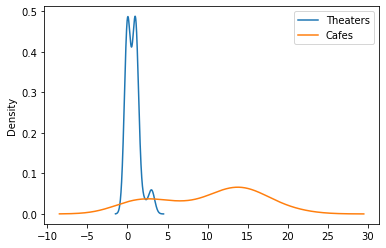

In [38]:
#Densityplot
Cafes_Theaters.plot.kde()

### The idea is to open the Theater-Cafe in a neighborhood, who does not have any Theaters and minimum number of Cafes

In [43]:
#list of Neighboorhood who does not have any Theater and min number of cafes
list_CT=[]
for i in range(len(Cafes_Theaters)):
    if Cafes_Theaters.values[i][1]==0:# and Cafes_Theaters.values[i][2]==Cafes_Theaters['Cafes'].min():
        list_CT.append(Cafes_Theaters.values[i])
list_CT
No_Theater=pd.DataFrame(list_CT) 
No_Theater.head()

,0,1,2
0,Bathurst Quay,0,1
1,Berczy Park,0,7
2,CN Tower,0,1
3,Cabbagetown,0,5
4,Central Bay Street,0,17


In [44]:
#we check these neighborhoods
No_Theater_info=neighborhoods.loc[neighborhoods['Neighbourhood'].isin(No_Theater_list)]
No_Theater_info.head()

,Borough,Neighbourhood,Latitude,Longitude


### Clustering the neighborhoods

- In order to choose between these neighborhood, it is logical to find a neighborhood, which is close to university or any colleges

In [92]:
Toronto_downtown_Universities=Toronto_downtown_venues[Toronto_downtown_venues['VCategory'].str.contains('University', regex=False, case=False, na=False)]
Toronto_downtown_Universities.shape
Toronto_downtown_Universities.head()
Toronto_downtown_Colleges=Toronto_downtown_venues[Toronto_downtown_venues['VCategory'].str.contains('College', regex=False, case=False, na=False)]
Toronto_downtown_Colleges.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,VCategory
131,Ryerson,43.657162,-79.378937,Ryerson Athletics Centre,43.658434,-79.379296,College Rec Center
231,Garden District,43.657162,-79.378937,Ryerson Athletics Centre,43.658434,-79.379296,College Rec Center
1551,Harbord,43.662696,-79.400049,Athletic Centre,43.662487,-79.400657,College Gym
1565,Harbord,43.662696,-79.400049,Innis Town Hall,43.665420,-79.399546,College Arts Building
1584,University of Toronto,43.662696,-79.400049,Athletic Centre,43.662487,-79.400657,College Gym


- We check for the minimum distance from teh neighboorhood, who have colleges and no Theaters

In [234]:
distances_list=[]
for i in range(len(Toronto_downtown_Colleges)):
    for j in range(len(No_Theater_info)):
        #print(i, Toronto_downtown_Colleges.values[i][4], Toronto_downtown_Colleges.values[i][5])
        #print(j, No_Theater_info.values[j][2], No_Theater_info.values[j][3])
        p1=Point(Toronto_downtown_Colleges.values[i][4], Toronto_downtown_Colleges.values[i][5])
        p2= Point(No_Theater_info.values[0][2], No_Theater_info.values[0][3])
        distances_list.append([No_Theater_info.values[i][1],No_Theater_info.values[j][0],distance.distance(p1,p2).kilometers])
distances_list

mindis=min(distances_list, key=lambda x: x[2])

[['Berczy Park', 'Downtown Toronto', 1.5931533817782009],
 ['Berczy Park', 'Downtown Toronto', 1.5931533817782009],
 ['Berczy Park', 'Downtown Toronto', 1.5931533817782009],
 ['Berczy Park', 'Downtown Toronto', 1.5931533817782009],
 ['Berczy Park', 'Downtown Toronto', 1.5931533817782009],
 ['Berczy Park', 'Downtown Toronto', 1.5931533817782009],
 ['Berczy Park', 'Downtown Toronto', 1.5931533817782009],
 ['Berczy Park', 'Downtown Toronto', 1.5931533817782009],
 ['Berczy Park', 'Downtown Toronto', 1.5931533817782009],
 ['Berczy Park', 'Downtown Toronto', 1.5931533817782009],
 ['Berczy Park', 'Downtown Toronto', 1.5931533817782009],
 ['Berczy Park', 'Downtown Toronto', 1.5931533817782009],
 ['Berczy Park', 'Downtown Toronto', 1.5931533817782009],
 ['Berczy Park', 'Downtown Toronto', 1.5931533817782009],
 ['Berczy Park', 'Downtown Toronto', 1.5931533817782009],
 ['Berczy Park', 'Downtown Toronto', 1.5931533817782009],
 ['Central Bay Street', 'Downtown Toronto', 1.5931533817782009],
 ['Cent

In [ ]:
print('The Theater-Cafe should be in a neighborhood between ' + mindis[0] + 'and ' +  mindis[1] )